## Looking at game scores.

Let's try looking at the scores of the games, and build a regression from those.  We start by loading the data into a dataframe, as in the NCAA Logistic Regression notebook.

In [30]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR
from sklearn.utils import shuffle

%matplotlib inline

# Load in the data
game_results = pd.read_csv('Data/NCAATourneyCompactResults.csv')[['Season','WTeamID','WScore','LTeamID','LScore']]
team_seeds = pd.read_csv('Data/NCAATourneySeeds.csv')

game_results.head()

team_seeds.head()

# Convert seed to numeric value.
seed_to_int = lambda x: int(''.join([s for s in x if not s.isalpha()]))
team_seeds['Seed'] = team_seeds['Seed'].apply(seed_to_int)

team_seeds.head()

# Merge these into a single dataframe
win_seeds = team_seeds.rename(columns={'TeamID':'WTeamID', 'Seed':'WSeed'})
loss_seeds = team_seeds.rename(columns={'TeamID':'LTeamID', 'Seed':'LSeed'})

merge_win = pd.merge(left=game_results,right=win_seeds,how='left',on=['Season','WTeamID'])
df = pd.merge(left=merge_win,right=loss_seeds,on=['Season','LTeamID'])
df['SeedDelta'] = df['WSeed'] - df['LSeed']

df.tail()

,Season,WTeamID,WScore,LTeamID,LScore,WSeed,LSeed,SeedDelta
2112,2017,1314,75,1246,73,1,2,-1
2113,2017,1376,77,1196,70,7,4,3
2114,2017,1211,77,1376,73,1,7,-6
2115,2017,1314,77,1332,76,1,3,-2
2116,2017,1314,71,1211,65,1,1,0


Now we can create a dataframe of seeds and scores.

In [31]:
win_scores = df[['WSeed','LSeed','WScore']].rename(columns={'WSeed':'TeamSeed', 'LSeed':'OppSeed','WScore':'Score'})
loss_scores = df[['LSeed','WSeed','LScore']].rename(columns={'LSeed':'TeamSeed', 'WSeed':'OppSeed','LScore':'Score'})

scores_df = pd.concat([win_scores,loss_scores])
scores_df.head()

,TeamSeed,OppSeed,Score
0,9,8,63
1,11,6,59
2,1,16,68
3,9,8,58
4,3,14,49


We can plot the mean score a team will record given their seed.  We can also record the mean score a team will record given their opponent's seed.

Text(0,0.5,'Mean Score')

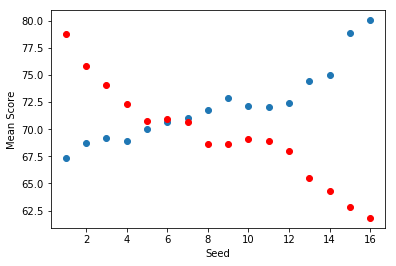

In [32]:
mean_team_score = []
for sd in range(1,17):
    mean_team_score.append(np.mean(scores_df[scores_df['TeamSeed']==sd]['Score'].values))
    
mean_opp_score = []
for sd in range(1,17):
    mean_opp_score.append(np.mean(scores_df[scores_df['OppSeed']==sd]['Score'].values))

plt.plot(range(1,17),mean_opp_score,'o')
plt.plot(range(1,17),mean_team_score,'ro')
plt.xlabel('Seed')
plt.ylabel('Mean Score')

Ok, makes sense - the better your seed, the more points you tend to score and the better your opponents seed the fewer points you tend to score.

Perhaps we can create a regression model to predict your score given your seed and your opponent's seed.  This can be combined with a logistic regression that classifies win/loss from points scored to predict win/loss from your seed and your opponents seed.

Let's try using support vector regression for this.

In [33]:
x_train = np.vstack([scores_df['TeamSeed'],scores_df['OppSeed']]).T

svr_reg = SVR(kernel='rbf', C=100, gamma=1.0) #guess the hyper-parameters for now
svr_reg.fit(x_train,scores_df['Score'].values)


SVR(C=100, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=1.0,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

We can plot the predictions across all possible permuations of (seed_i,seed_j) in a 3d scatter plot.  

Text(0.5,0,'Score')

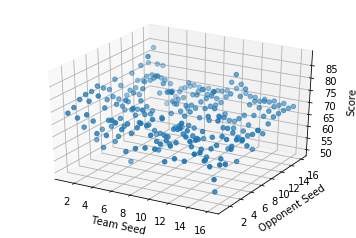

In [34]:
from mpl_toolkits.mplot3d import Axes3D
x,y=np.meshgrid(range(1,17),range(1,17))
xy = list(zip(x.flatten(),y.flatten()))

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.flatten(),y.flatten(),svr_reg.predict(xy))
ax.set_xlabel('Team Seed')
ax.set_ylabel('Opponent Seed')
ax.set_zlabel('Score')

Not great, we expect a relatively smooth surface but instead we see clear overfitting here.  We can use a grid search to optimize this based off of cross validations.

In [35]:
from sklearn.model_selection import GridSearchCV
params = {'C':np.logspace(0,4,5),'gamma':np.logspace(-4,0,5)}

svr_reg = GridSearchCV(SVR(kernel='rbf',gamma=0.1), param_grid=params)
svr_reg.fit(x_train,scores_df['Score'].values)

print('Best log_loss: {:.4}, with best C: {} and best gamma: {}'.format(svr_reg.best_score_, svr_reg.best_params_['C'],svr_reg.best_params_['gamma']))

Best log_loss: -0.2827, with best C: 100.0 and best gamma: 0.01


Ok we get much different parameters from this search.  Let's see what that looks like:

Text(0.5,0,'Score')

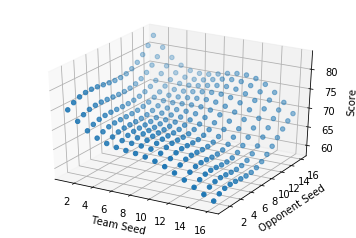

In [36]:
fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.flatten(),y.flatten(),svr_reg.predict(xy))
ax.set_xlabel('Team Seed')
ax.set_ylabel('Opponent Seed')
ax.set_zlabel('Score')

Much better.  We'll stick with this model.

## Creating a logistic regression of scores

We now need a logistic regression to classify win/loss based off of score.

In [37]:
#get dataframe
wins = pd.DataFrame()
wins['points'] = df['WScore']
wins['Result'] = 1

loss = pd.DataFrame()
loss['points'] = df['LScore']
loss['Result'] = 0

predictions = pd.concat([wins,loss])
predictions.head()

,points,Result
0,63,1
1,59,1
2,68,1
3,58,1
4,49,1


Text(0,0.5,'Result (Win = 1)')

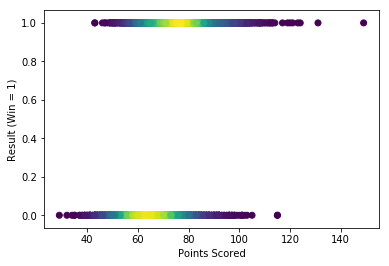

In [38]:
from scipy.stats import gaussian_kde
#plot density estimate
xy = np.vstack([predictions.values.T[0],predictions.values.T[1]])
de = gaussian_kde(xy)(xy)

plt.scatter(predictions['points'],predictions['Result'],c=de)
plt.xlabel('Points Scored')
plt.ylabel('Result (Win = 1)')

Text(0,0.5,'Mean Result')

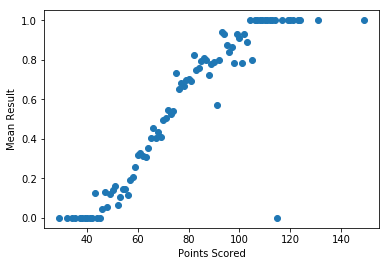

In [39]:
#get mean results at each seed difference
delta_vals = np.unique(predictions['points'].values)
mean_result = []
for val in delta_vals:
    mean_result.append(np.mean(predictions[predictions['points']==val]['Result'].values))

#plot mean results
plt.plot(delta_vals,mean_result,'o')
plt.xlabel('Points Scored')
plt.ylabel('Mean Result')

Text(0,0.5,'Mean Result')

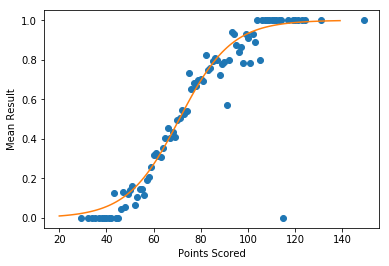

In [40]:
#split up into features and ground truth
x_train = predictions['points'].values.reshape(-1,1)
y_train = predictions['Result'].values
x_train,y_train = shuffle(x_train,y_train)

#create classifier and train
logistic_reg = LogisticRegression(C=1000) #C is inverse of regularization strength
logistic_reg.fit(x_train,y_train)

#plot resulting probability
xvals = np.arange(20,140).reshape(-1,1)
p=logistic_reg.predict_proba(xvals)[:,1]

plt.plot(delta_vals,mean_result,'o')
plt.plot(xvals,p)

plt.xlabel('Points Scored')
plt.ylabel('Mean Result')

## Test our predictions

Let's now test this model.

In [41]:
win_team = pd.DataFrame()
win_team['TeamSeed'] = df['WSeed']
win_team['OppSeed'] = df['LSeed']
win_team['Result'] = 1

win_team.head()

,TeamSeed,OppSeed,Result
0,9,8,1
1,11,6,1
2,1,16,1
3,9,8,1
4,3,14,1


In [42]:
#predict from model and get accuracy
X = np.vstack([win_team['TeamSeed'],win_team['OppSeed']]).T
X_flip = np.vstack([win_team['OppSeed'],win_team['TeamSeed']]).T
pred_score = svr_reg.predict(X).reshape(-1,1)
pred_score_flip = svr_reg.predict(X_flip).reshape(-1,1)

logreg_preds = 1-logistic_reg.predict_proba(pred_score_flip)
np.mean(logreg_preds[:,1]>.5)

0.76381672177609827

In [43]:
#get log loss
gt = np.zeros_like(logreg_preds)
gt[:,1]=1.0
logloss = sklearn.metrics.log_loss(gt,logreg_preds)
print(logloss)

0.587148276878


Ok, doesn't seem to improve.  Let's try looking at the regular season.

## Regular season statistics

We can try to get the mean score of each team in the tourney over the regular season.  Higher seeds may trend to scoring more over the regular season.  To start, let's just look at a single season (1985).

In [44]:
reg_season = pd.read_csv('Data/RegularSeasonCompactResults.csv')
reg_season = reg_season[reg_season['Season']==1985]
reg_season.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,20,1228,81,1328,64,N,0
1,1985,25,1106,77,1354,70,H,0
2,1985,25,1112,63,1223,56,H,0
3,1985,25,1165,70,1432,54,H,0
4,1985,25,1192,86,1447,74,H,0


Let's clean this up to only include the teams, scores, and result.

In [45]:
win_scores = reg_season[['WTeamID','LTeamID','WScore','LScore']].rename(columns={'WTeamID':'Team','LTeamID':'OppTeam','WScore':'Score For','LScore':'Score Against'})
win_scores['Result'] = 1
lose_scores = reg_season[['LTeamID','WTeamID','LScore','WScore']].rename(columns={'LTeamID':'Team','WTeamID':'OppTeam','LScore':'Score For','WScore':'Score Against'})
lose_scores['Result'] = 0

reg_scores = pd.concat([win_scores,lose_scores])

reg_scores.tail()

,Team,OppTeam,Score For,Score Against,Result
3732,1217,1463,69,70,0
3733,1283,1183,64,75,0
3734,1314,1210,62,67,0
3735,1231,1276,71,73,0
3736,1116,1403,64,67,0


Ok, now we can compute the mean score (for and against) of each team across the season.

In [46]:
mean_scores=reg_scores.groupby('Team').mean().reset_index()[['Team','Score For','Score Against']]
mean_scores.head()

,Team,Score For,Score Against
0,1102,63.083333,68.875000
1,1103,61.043478,64.086957
2,1104,68.500000,60.700000
3,1106,71.625000,75.416667
4,1108,83.000000,75.040000


Let's merge this to include teams, scores and results.

In [47]:
scores_merge = reg_scores[['Team','Result']].merge(mean_scores,how='left')
opp_merge = reg_scores[['OppTeam','Result']].rename(columns={'OppTeam':'Team'}).merge(mean_scores,how='left')
scores_merge['OppTeam'] = opp_merge['Team']
scores_merge['OppScore For'] = opp_merge['Score For']
scores_merge['OppScore Against'] = opp_merge['Score Against']
scores_merge.head()

,Team,Result,Score For,Score Against,OppTeam,OppScore For,OppScore Against
0,1228,1,68.225806,57.354839,1328,89.833333,76.533333
1,1106,1,71.625000,75.416667,1354,68.208333,71.791667
2,1112,1,66.518519,59.333333,1223,68.320000,63.720000
3,1165,1,61.375000,59.083333,1432,63.478261,62.869565
4,1192,1,67.892857,64.714286,1447,73.333333,78.000000


Let's aggregate a team's offensive ability (mean points scored) with their opponent's defensive ability (mean points their opponent gives up).  We call this OvsD.  Similary we can aggregate a team's defensive ability (mean points given up) with their opponent's offensive ability (mean points their opponent score).  We call this DvsO.

We therefore expect that the larger the OvsD value, and the smaller the DvsO value, the more likely you are to win.

Text(0,0.5,'Result')

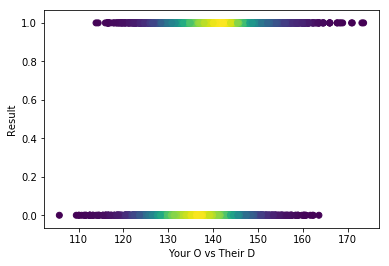

In [48]:
#compute OvsD and DvsO values
OvsD = scores_merge['Score For'].values + scores_merge['OppScore Against'].values
DvsO = scores_merge['Score Against'].values + scores_merge['OppScore For'].values
result = scores_merge['Result'].values

#plot density of result for OvsD values
xy = np.vstack([OvsD.T,result])
de = gaussian_kde(xy)(xy)

plt.scatter(OvsD,scores_merge['Result'].values,c=de)
plt.xlabel('Your O vs Their D')
plt.ylabel('Result')

Ok makes sense, the larger your OvsD value, the more likely you are to win.  Let's create a logistic regression model for both OvsD and DvsO to predict the result.

In [49]:
#split up into features and ground truth
x_train = np.vstack([OvsD,DvsO]).T
y_train = result
x_train,y_train = shuffle(x_train,y_train)

#create classifier and train
logistic_reg = LogisticRegression(C=1000) #C is inverse of regularization strength
logistic_reg.fit(x_train,y_train)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

We now plot the resulting regression in 3d space.

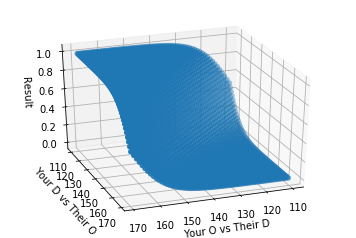

In [50]:
from mpl_toolkits.mplot3d import Axes3D
#plot resulting probability
x,y=np.meshgrid(range(110,170),range(110,170))
xy = list(zip(x.flatten(),y.flatten()))
p=logistic_reg.predict_proba(xy)[:,1]

fig=plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x.flatten(),y.flatten(),p)
ax.set_xlabel('Your O vs Their D')
ax.set_ylabel('Your D vs Their O')
ax.set_zlabel('Result')
ax.view_init(30, 70)

## Regular Season Scores combined with Seed Difference

Ok regular season scores provide some signal.  Perhaps combining this with seed difference will create an improved regression.

In [51]:
#read in data
reg_season = pd.read_csv('Data/RegularSeasonCompactResults.csv')

win_scores = reg_season[['Season','WTeamID','LTeamID','WScore','LScore']].rename(columns={'WTeamID':'Team','LTeamID':'OppTeam','WScore':'Score For','LScore':'Score Against'})
win_scores['Result'] = 1
lose_scores = reg_season[['Season','LTeamID','WTeamID','LScore','WScore']].rename(columns={'LTeamID':'Team','WTeamID':'OppTeam','LScore':'Score For','WScore':'Score Against'})
lose_scores['Result'] = 0

#combine wins and losses
reg_scores = pd.concat([win_scores,lose_scores])

#rename team identifier to include season
reg_scores['Team'] = reg_scores['Season'].map(str)+'_'+reg_scores['Team'].map(str)
reg_scores['OppTeam'] = reg_scores['Season'].map(str)+'_'+reg_scores['OppTeam'].map(str)
reg_scores=reg_scores.drop('Season',axis=1)

reg_scores.tail()

,Team,OppTeam,Score For,Score Against,Result
150679,2017_1458,2017_1276,56,71,0
150680,2017_1463,2017_1343,59,71,0
150681,2017_1433,2017_1348,63,70,0
150682,2017_1153,2017_1374,56,71,0
150683,2017_1402,2017_1407,53,59,0


Similar to above, we find the mean scores for and against each team.

In [52]:
mean_scores=reg_scores.groupby('Team').mean().reset_index()[['Team','Score For','Score Against']]
mean_scores.tail()

,Team,Score For,Score Against
10532,2017_1460,75.700000,74.300000
10533,2017_1461,77.466667,76.900000
10534,2017_1462,74.617647,71.352941
10535,2017_1463,73.178571,70.785714
10536,2017_1464,76.000000,83.187500


Now let's create a dataframe of all games played

In [53]:
df_OD = pd.DataFrame()
df_OD['Team'] = df['Season'].map(str)+'_'+df['WTeamID'].map(str)
df_OD['OppTeam'] = df['Season'].map(str)+'_'+df['LTeamID'].map(str)
df_OD=df_OD.rename(columns={'OppTeam':'Opponent'})

df_OD.tail()

,Team,Opponent
2112,2017_1314,2017_1246
2113,2017_1376,2017_1196
2114,2017_1211,2017_1376
2115,2017_1314,2017_1332
2116,2017_1314,2017_1211


For each game, lets include the OvsD and DvsO value.

In [54]:
def findOD(row):
    team_m_scores = mean_scores[mean_scores['Team']==row['Team']]
    opp_m_scores = mean_scores[mean_scores['Team']==row['Opponent']]
    OvsD = team_m_scores['Score For'].values + opp_m_scores['Score Against'].values
    DvsO = team_m_scores['Score Against'].values + opp_m_scores['Score For'].values
    
    row['OvsD'] = OvsD[0]
    row['DvsO'] = DvsO[0]
    return row

df_OD=df_OD.apply(findOD,axis=1)
df_OD.tail()

,Team,Opponent,OvsD,DvsO
2112,2017_1314,2017_1246,155.921569,156.850267
2113,2017_1376,2017_1196,138.046371,142.829637
2114,2017_1211,2017_1376,149.124145,132.635386
2115,2017_1314,2017_1332,149.696970,149.575758
2116,2017_1314,2017_1211,145.484848,155.484848


For each game we also need the seed difference.

In [55]:
wins = pd.DataFrame()
wins['SeedDelta'] = df['SeedDelta']
wins['OvsD'] = df_OD['OvsD']
wins['DvsO'] = df_OD['DvsO']
wins['Result'] = 1

loss = pd.DataFrame()
loss['SeedDelta'] = -df['SeedDelta']
loss['OvsD'] = df_OD['DvsO']
loss['DvsO'] = df_OD['OvsD']
loss['Result'] = 0

predictions = pd.concat([wins,loss])
predictions['Season'] = df['Season']
predictions.tail()

,SeedDelta,OvsD,DvsO,Result,Season
2112,1,156.850267,155.921569,0,2017
2113,-3,142.829637,138.046371,0,2017
2114,6,132.635386,149.124145,0,2017
2115,2,149.575758,149.696970,0,2017
2116,0,155.484848,145.484848,0,2017


Ok to test this regression, let's split up our data to train on all games before 2014 and test on games from 2014 on.  

For comparison we can also train a logistic regression model on ONLY seed difference data (as in NCAA Logistic Regression notebook).

In [56]:
#split up into train and test data
train_data = predictions[predictions['Season']<2014]
test_data = predictions[predictions['Season']>=2014]

#split up into features and ground truth (all features)
x_train = train_data[['SeedDelta','OvsD','DvsO']].values
y_train = train_data['Result']
x_train,y_train = shuffle(x_train,y_train)

#split up into features and ground truth (only seed difference)
x_train_seed_only = train_data[['SeedDelta']].values
y_train_seed_only = train_data['Result']
x_train_seed_only,y_train_seed_only = shuffle(x_train_seed_only,y_train_seed_only)

#create classifier and train (all features)
logistic_reg = LogisticRegression(C=1000) #C is inverse of regularization strength
logistic_reg.fit(x_train,y_train)

#create classifier and train (only seed difference)
logistic_reg_seed_only = LogisticRegression(C=1000) #C is inverse of regularization strength
logistic_reg_seed_only.fit(x_train_seed_only,y_train_seed_only)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

Let's check out our resulting log loss.

In [57]:
#get feature data to predict on
X = np.vstack([test_data['SeedDelta'],test_data['OvsD'],test_data['DvsO']]).T
X_seed_only = np.vstack([test_data['SeedDelta']]).T

#make predictions
p=logistic_reg.predict_proba(X)
p_seed_only = logistic_reg_seed_only.predict_proba(X_seed_only)

#gather ground truth
gt = np.zeros_like(p)
gt[:,1]=test_data['Result'].values
gt[:,0] = 1 - gt[:,1]

#compare log loss
logloss = sklearn.metrics.log_loss(gt,p)
logloss_seed_only = sklearn.metrics.log_loss(gt,p_seed_only)

print('Seed Difference Log Loss is %1.4f'%logloss_seed_only)
print('All Features Log Loss is %1.4f'%logloss)

Seed Difference Log Loss is 0.5712
All Features Log Loss is 0.5578


We see that using OvsD and DvsO with seed difference is an improvement over only seed difference.

## Create submission

This follows the tutorial on kaggle.

In [33]:
def addTeamIDs(row):
    teamIDs = row['ID'].split('_')
    
    row['Team'] = teamIDs[0]+'_'+teamIDs[1]
    row['Opponent'] = teamIDs[0]+'_'+teamIDs[2]
    
    return row

df_sample = pd.read_csv('Data/SampleSubmissionStage1.csv')

df_sample = df_sample.apply(addTeamIDs,axis=1)
df_sample = df_sample.drop('ID',axis=1)
df_sample.head()

,Pred,Team,Opponent
0,0.5,2014_1107,2014_1110
1,0.5,2014_1107,2014_1112
2,0.5,2014_1107,2014_1113
3,0.5,2014_1107,2014_1124
4,0.5,2014_1107,2014_1140


In [34]:
team_seeds = pd.read_csv('Data/NCAATourneySeeds.csv')

seed_to_int = lambda x: int(''.join([s for s in x if not s.isalpha()]))
team_seeds['Seed'] = team_seeds['Seed'].apply(seed_to_int)

team_seeds['Team'] = team_seeds['Season'].map(str)+'_'+team_seeds['TeamID'].map(str)
team_seeds = team_seeds.drop('TeamID',1).drop('Season',1)
team_seeds.head()

,Seed,Team
0,1,1985_1207
1,2,1985_1210
2,3,1985_1228
3,4,1985_1260
4,5,1985_1374


In [35]:
def findSeedDiff(row):
    teamId = row['Team']
    oppId = row['Opponent']
    
    teamSeed = team_seeds[team_seeds['Team']==teamId]['Seed'].values[0]
    oppSeed = team_seeds[team_seeds['Team']==oppId]['Seed'].values[0]
    row['SeedDiff'] = teamSeed - oppSeed
    return row

df_sample=df_sample.apply(findSeedDiff,1)
df_sample.head()

,Pred,Team,Opponent,SeedDiff
0,0.5,2014_1107,2014_1110,1
1,0.5,2014_1107,2014_1112,15
2,0.5,2014_1107,2014_1113,6
3,0.5,2014_1107,2014_1124,10
4,0.5,2014_1107,2014_1140,6


In [607]:
df_sample = df_sample.apply(findOD,axis=1)
df_sample.head()

,Pred,Team,Opponent,SeedDiff,OvsD,DvsO
0,0.5,2014_1107,2014_1110,1,124.656250,127.781250
1,0.5,2014_1107,2014_1112,15,124.178309,136.902574
2,0.5,2014_1107,2014_1113,6,134.906250,138.875000
3,0.5,2014_1107,2014_1124,10,134.425189,137.631629
4,0.5,2014_1107,2014_1140,6,143.576705,148.055871


In [614]:
X = np.vstack([df_sample['SeedDiff'],df_sample['OvsD'],df_sample['DvsO']]).T
preds=logistic_reg.predict_proba(X)[:,1]

clipped_preds = np.clip(preds, 0.02, 0.98)
df_sample['Pred'] = clipped_preds
df_sample.head()

,Pred,Team,Opponent,SeedDiff,OvsD,DvsO
0,0.419178,2014_1107,2014_1110,1,124.656250,127.781250
1,0.054782,2014_1107,2014_1112,15,124.178309,136.902574
2,0.254999,2014_1107,2014_1113,6,134.906250,138.875000
3,0.170389,2014_1107,2014_1124,10,134.425189,137.631629
4,0.249239,2014_1107,2014_1140,6,143.576705,148.055871


In [615]:
df_out = pd.read_csv('Data/SampleSubmissionStage1.csv')

df_out['Pred'] = df_sample['Pred']
df_out.to_csv('logreg_seed_pts.csv', index=False)